In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spec
import pandas as pd
from astropy.io import ascii
import scipy.stats as stats
from ipywidgets import FloatProgress
from IPython.display import display
import requests
import astropy.units as u
from astropy.coordinates import SkyCoord

Get the KOI catalog from the archive (if we don't already have it)

In [2]:
if False:
    from cStringIO import StringIO # only works in python 2.7
    urlDr25Koi = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=q1_q17_dr25_koi&select=*"

    r = requests.get(urlDr25Koi)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    dr25Koi = pd.read_csv(fh, dtype={"kepoi_name":str})
    dr25Koi.to_csv("dr25_kois_archive.txt", index=False)
else:
    dr25Koi = pd.read_csv("dr25_kois_archive.txt", dtype={"kepoi_name":str})

print("Loaded " + str(len(dr25Koi)) + " KOIs")



Loaded 8054 KOIs


Get the certified false positive table.  We have to download it manually.

In [3]:
cfpTableName = "fpwg_2019.09.16_18.35.55.csv"
archiveCfpTable = pd.read_csv(cfpTableName, dtype={"kepoi_name":str}, header=71)


Get the DR25 stellar catalog with updates from Savita's supplement

In [4]:
starlist = "dr25_stellar_updated_feh_all.txt"
kic = pd.read_csv(starlist)
# add absolute magnitude
kic['absoluteKepmag'] = kic.kepmag - 5 * np.log10(kic.dist/10);

/Users/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


Now we'll merge these tables together, starting by merging the cfpTable and dr25Koi, using kepoi_name as the key.

Add RGB colors corresponding to the teff

In [5]:
teffColors = pd.read_csv("teffColorTable.txt", delim_whitespace=True, comment='#', dtype={"bitcode":object})
teffColors = teffColors[teffColors.type=="2deg"]
# interpolate teff onto RGB
kic["teffR"] = np.interp(kic.teff, teffColors.temp, teffColors.R)
kic["teffG"] = np.interp(kic.teff, teffColors.temp, teffColors.G)
kic["teffB"] = np.interp(kic.teff, teffColors.temp, teffColors.B)

In [6]:
cfpTable = pd.merge(archiveCfpTable, dr25Koi, on="kepoi_name", how="inner")
# the only column common to both is kepid, so rename kepid_x to kepid and drop kepid_y
cfpTable["kepid"] = cfpTable["kepid_x"]
cfpTable = cfpTable.drop(["kepid_x", "kepid_y"], axis=1)


Now merge with the stellar table, using "kepid" as the key

In [7]:
cfpTable = pd.merge(cfpTable, kic, on="kepid", how="inner")
# drop ra and dec 
cfpTable["ra"] = cfpTable["ra_x"]
cfpTable["dec"] = cfpTable["dec_x"]
cfpTable = cfpTable.drop(["ra_x", "dec_x", "ra_y", "dec_y"], axis=1)


In [8]:
len(cfpTable)

8054

Now cfpTable contains everything we want to know about each entry

Let's add Galactic coordinates

In [9]:
# only works in python 3
c = SkyCoord(ra=cfpTable.ra*u.degree, dec=cfpTable.dec*u.degree, frame='icrs')
galLong = np.array(c.galactic.l)
galLat = np.array(c.galactic.b)
cfpTable["galLong"] = galLong
cfpTable["galLat"] = galLat


In [10]:
list(cfpTable)

['rowid',
 'kepoi_name',
 'fpwg_koi_period',
 'fpwg_disp_status',
 'fpwg_disp_source',
 'fpwg_disp_eb',
 'fpwg_disp_offst',
 'fpwg_disp_perep',
 'fpwg_disp_other',
 'fpwg_flux_ss',
 'fpwg_flux_slflum',
 'fpwg_flux_oedp',
 'fpwg_flux_vshape',
 'fpwg_flux_depth',
 'fpwg_flux_dilutn',
 'fpwg_flux_lcurve',
 'fpwg_flux_ootvar',
 'fpwg_flux_corvar',
 'fpwg_flux_other',
 'fpwg_flux_stellr',
 'fpwg_flux_noteb',
 'fpwg_offst_sig',
 'fpwg_offst_badim',
 'fpwg_offst_inval',
 'fpwg_offst_vis',
 'fpwg_offst_star',
 'fpwg_offst_qvars',
 'fpwg_offst_other',
 'fpwg_offst_nooff',
 'fpwg_perep_match',
 'fpwg_perep_direc',
 'fpwg_perep_col',
 'fpwg_perep_ghost',
 'fpwg_perep_video',
 'fpwg_perep_ref',
 'fpwg_fa_starvar',
 'fpwg_fa_unique',
 'fpwg_fa_thermal',
 'fpwg_fa_ntl',
 'fpwg_fa_artifact',
 'fpwg_fa_other',
 'fpwg_fa_notfa',
 'fpwg_fop_rvs1',
 'fpwg_fop_rvs2',
 'fpwg_fop_rvs3',
 'fpwg_fop_dblline',
 'fpwg_fop_imexam',
 'fpwg_fop_imblend',
 'fpwg_efp_public',
 'fpwg_efp_pubexam',
 'fpwg_efp_accept',

In [11]:
cfpTable.to_csv("cfpTable.csv")

Now add the stellar properties from Berger et al 2018 with improved radii.  This catalog has significantly fewer stars, so the cfp table with Berger will have fewer entries

In [12]:
from astropy.io import ascii

# read the publised table from Berger et. al. 
gaiaUpdates = ascii.read("apj_table1_published.txt")

gaiaUpdatesPd = gaiaUpdates.to_pandas();
# merge with kic to get kepmag
gaiaUpdatesPd = pd.merge(kic[['kepid','kepmag']], gaiaUpdatesPd, left_on="kepid", right_on="KIC", how="inner")
# add absolute magnitude
gaiaUpdatesPd['absoluteKepmagBerger'] = gaiaUpdatesPd.kepmag - 5 * np.log10(gaiaUpdatesPd.D/10);
# interpolate color for effective temperature
gaiaUpdatesPd["TeffR"] = np.interp(gaiaUpdatesPd.Teff, teffColors.temp, teffColors.R)
gaiaUpdatesPd["TeffG"] = np.interp(gaiaUpdatesPd.Teff, teffColors.temp, teffColors.G)
gaiaUpdatesPd["TeffB"] = np.interp(gaiaUpdatesPd.Teff, teffColors.temp, teffColors.B)
# now drop kepmag and kepid
gaiaUpdatesPd = gaiaUpdatesPd.drop(columns=['kepid','kepmag'])

cfpTableBerger = pd.merge(cfpTable, gaiaUpdatesPd, left_on="kepid", right_on="KIC", how="inner")

# for convenience put the Berger radius in the same format as the DR25 radius
# copy Gaia radius to the dr25 radius column
cfpTableBerger["radiusBerger"] = cfpTableBerger["R*"]
# for DR25, err1 is the upper uncertainty, err2 is the lower uncertainty and is < 0
# for Gaia, E_R* is the upper uncertainty, E_R* is the lower uncertainty and is > 0
cfpTableBerger["radiusBerger_err1"] = cfpTableBerger["E_R*"]
cfpTableBerger["radiusBerger_err2"] = -cfpTableBerger["e_R*"]


In [13]:
# correct the planet radii with the new catalog

rEarth = 6356.8 # km
rSun = 695700 # km

cfpTableBerger['corrected_prad'] = cfpTableBerger['koi_ror']*cfpTableBerger['radiusBerger']*rSun/rEarth;
cfpTableBerger['corrected_prad_err1'] = np.sqrt(cfpTableBerger['koi_ror_err1']**2*cfpTableBerger['radiusBerger']**2
                                        +cfpTableBerger['koi_ror']**2*cfpTableBerger['radiusBerger_err1']**2)*rSun/rEarth;
cfpTableBerger['corrected_prad_err2'] = -np.sqrt(cfpTableBerger['koi_ror_err2']**2*cfpTableBerger['radiusBerger']**2
                                        +cfpTableBerger['koi_ror']**2*cfpTableBerger['radiusBerger_err2']**2)*rSun/rEarth;



In [14]:
cfpTableBerger.to_csv("cfpTable_Berger2018.csv")

In [15]:
list(cfpTableBerger)

['rowid',
 'kepoi_name',
 'fpwg_koi_period',
 'fpwg_disp_status',
 'fpwg_disp_source',
 'fpwg_disp_eb',
 'fpwg_disp_offst',
 'fpwg_disp_perep',
 'fpwg_disp_other',
 'fpwg_flux_ss',
 'fpwg_flux_slflum',
 'fpwg_flux_oedp',
 'fpwg_flux_vshape',
 'fpwg_flux_depth',
 'fpwg_flux_dilutn',
 'fpwg_flux_lcurve',
 'fpwg_flux_ootvar',
 'fpwg_flux_corvar',
 'fpwg_flux_other',
 'fpwg_flux_stellr',
 'fpwg_flux_noteb',
 'fpwg_offst_sig',
 'fpwg_offst_badim',
 'fpwg_offst_inval',
 'fpwg_offst_vis',
 'fpwg_offst_star',
 'fpwg_offst_qvars',
 'fpwg_offst_other',
 'fpwg_offst_nooff',
 'fpwg_perep_match',
 'fpwg_perep_direc',
 'fpwg_perep_col',
 'fpwg_perep_ghost',
 'fpwg_perep_video',
 'fpwg_perep_ref',
 'fpwg_fa_starvar',
 'fpwg_fa_unique',
 'fpwg_fa_thermal',
 'fpwg_fa_ntl',
 'fpwg_fa_artifact',
 'fpwg_fa_other',
 'fpwg_fa_notfa',
 'fpwg_fop_rvs1',
 'fpwg_fop_rvs2',
 'fpwg_fop_rvs3',
 'fpwg_fop_dblline',
 'fpwg_fop_imexam',
 'fpwg_fop_imblend',
 'fpwg_efp_public',
 'fpwg_efp_pubexam',
 'fpwg_efp_accept',

(0, 5)

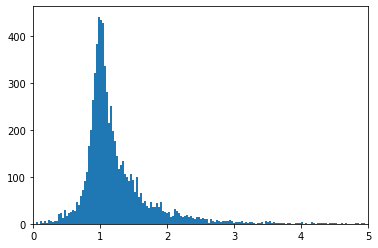

In [16]:
plt.hist(cfpTableBerger.radiusBerger/cfpTableBerger.radius, 1000);
plt.xlim(0,5)

/Users/steve/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/steve/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


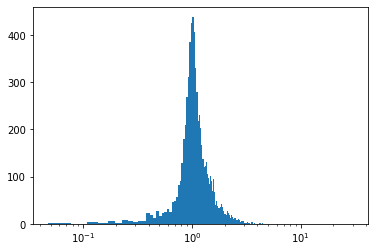

In [17]:
plt.hist(cfpTableBerger.corrected_prad/cfpTableBerger.koi_prad, 1000);
#plt.yscale('log')
plt.xscale('log')


In [18]:
list(gaiaUpdatesPd)

['KIC',
 'Gaia',
 'Teff',
 'e_Teff',
 'D',
 'E_D',
 'e_D',
 'R*',
 'E_R*',
 'e_R*',
 'AV',
 'Evol',
 'Bin',
 'absoluteKepmagBerger',
 'TeffR',
 'TeffG',
 'TeffB']

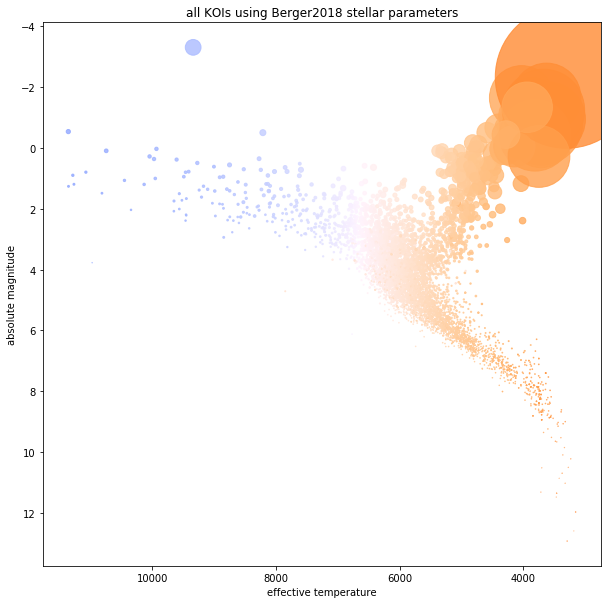

In [45]:
plt.figure(figsize=(10,10))
plt.scatter(cfpTableBerger.teff, cfpTableBerger.absoluteKepmagBerger, alpha=0.8, 
            c = np.transpose([cfpTableBerger["TeffR"],cfpTableBerger["TeffG"],cfpTableBerger["TeffB"]]), 
            s = cfpTableBerger["R*"]**2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title('all KOIs using Berger2018 stellar parameters');
plt.xlabel('effective temperature');
plt.ylabel('absolute magnitude');

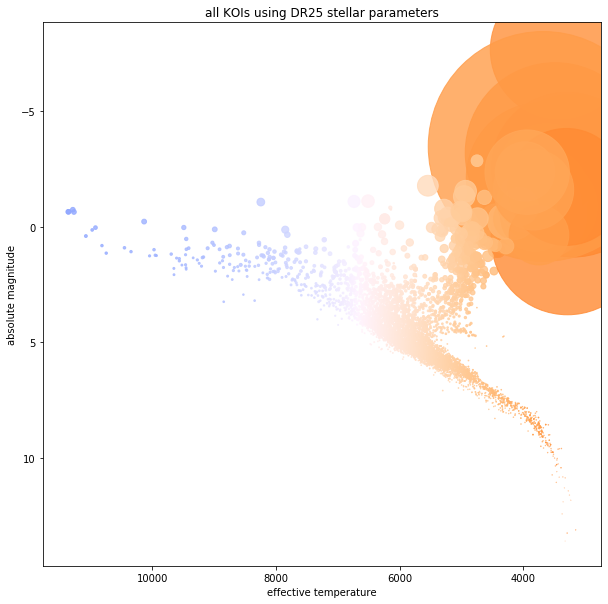

In [46]:
plt.figure(figsize=(10,10))
plt.scatter(cfpTable.teff, cfpTable.absoluteKepmag, alpha=0.8, 
            c = np.transpose([cfpTable["teffR"],cfpTable["teffG"],cfpTable["teffB"]]), 
            s = cfpTable.radius**2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title('all KOIs using DR25 stellar parameters');
plt.xlabel('effective temperature');
plt.ylabel('absolute magnitude');

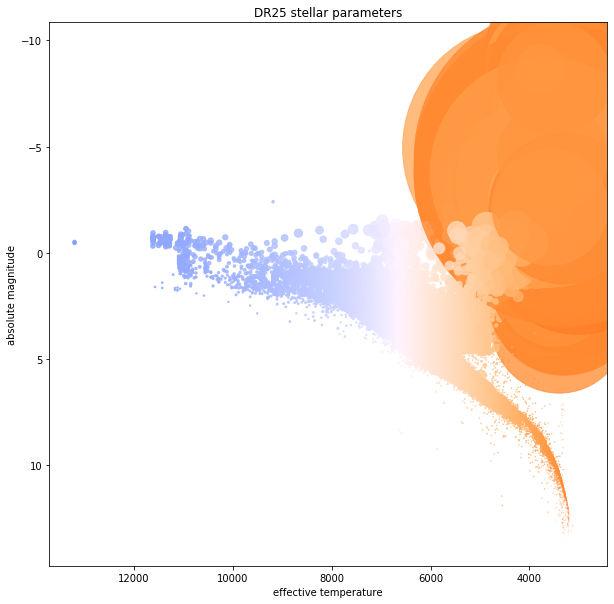

In [47]:
plt.figure(figsize=(10,10))
plt.scatter(kic.teff, kic.absoluteKepmag, alpha=0.8, 
            c = np.transpose([kic["teffR"],kic["teffG"],kic["teffB"]]), 
            s = kic.radius**2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
xl = plt.xlim()
yl = plt.ylim()
plt.title('DR25 stellar parameters');
plt.xlabel('effective temperature');
plt.ylabel('absolute magnitude');

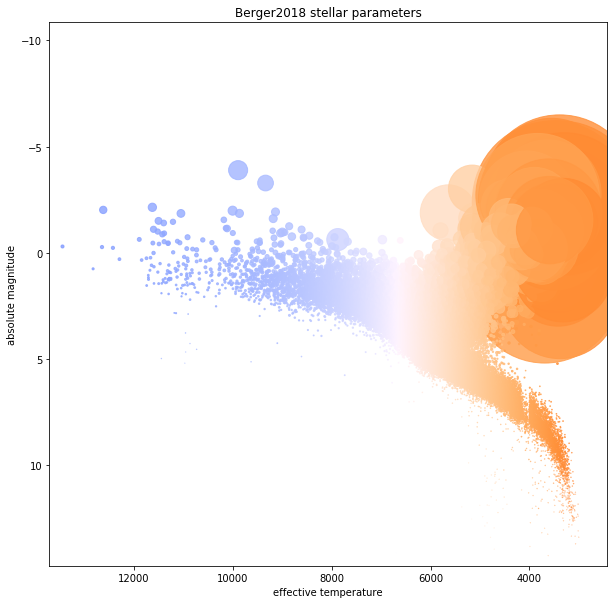

In [48]:
plt.figure(figsize=(10,10))
plt.scatter(gaiaUpdatesPd.Teff, gaiaUpdatesPd.absoluteKepmagBerger, alpha=0.8, 
            c = np.transpose([gaiaUpdatesPd["TeffR"],gaiaUpdatesPd["TeffG"],gaiaUpdatesPd["TeffB"]]), 
            s = gaiaUpdatesPd["R*"]**2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlim(xl);
plt.ylim(yl);
plt.title('Berger2018 stellar parameters');
plt.xlabel('effective temperature');
plt.ylabel('absolute magnitude');